# Tutorial Part 03 - How to reuse the QUBO formulation

In [1]:
import networkx as nx
import numpy as np

In [2]:
from quark import PolyBinary, ObjectiveTerms
from quark.io import Instance

Often you might want to test your quantum algorithm approach to multiple different use-cases. Or you want to try different mappings of your original problem to QUBO form.
In this tutorial we will introduce classes that abstract away the specifics of the use-case and the mapping. On top of this other tools like Cirq, Qiskit or D-Wave Ocean can be used.

## What we will learn

In Tutorial 01, we saw that we might have various contributions to the QUBO. E.g. the original cost function and a contribution enforcing the constraint (a penalty term). Here we will introduce

 1. how to define an ``Instance`` class at the example of the Maximum k-colorable Subgraph Problem, 
 2. how to define the QUBO terms in an ``ObjectiveTerms`` class which handles each contribution to the QUBO/ISING cost function (without the penalty factors fixed) and
 3. how to get the ``Objective`` which is a container for any cost function (e.g. a QUBO with fixed penalty factors).

## 1. The Max-$k$-colorable Subgraph Problem Instance

### A General problem instance

First, we create a problem instance class for the general combinatorial optimization problem Serving as a placeholder for all problems of this type. 

The instance consist of

 - The set of edges $E$ (implicitly defining $G=(N, E)$)
 - The number of colors $k$.
 
A basic instance could be defined as follows:

In [3]:
class MaxKColorableSubgraphInstance(Instance):
    
    def __init__(self, edges, num_colors):
        """ initialize max-k-colorable subgraph problem
        Args:
            edges(list): list of tuples representing edges of the graph
            num_colors(int): number of colors
        """
        self.edges = edges
        self.nodes = sorted(set(node for edge in self.edges for node in edge))
        self.num_colors = num_colors
        super().__init__()
        
    def check_consistency(self):
        for edges in self.edges:
            if len(edges) != 2:
                raise ValueError("Instance is not consistent. Edges need to have two nodes.")
        if self.num_colors < 1:
            raise ValueError("Instance is not consistent. We need at least one color.")
        return True

**Note**: In order use quarks advanced i/o features the instance needs to be inherited from ``quark.io.Instance``. However to keep things simple we will not implement i/o funcitons here. See for ``quark.testing.ExampleInstance`` for how this is done.

### Example instance

With same example data es before we can instantiate an instance object

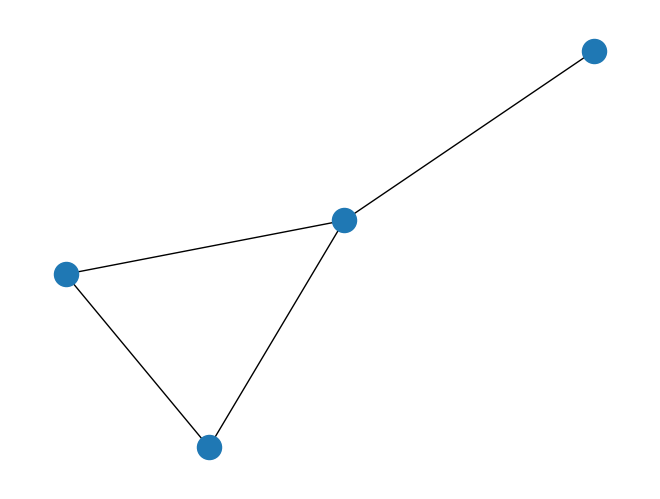

In [4]:
num_colors = 3
edges = [('a', 'b'), ('b', 'c'), ('b', 'd'), ('c', 'd')]

instance = MaxKColorableSubgraphInstance(edges=edges, num_colors=num_colors)
nx.draw(nx.Graph(instance.edges))

Now we can use this instance to define our qubo terms analogously to before with

The first contribution of the QUBO, $\displaystyle C = \sum_{(n, m)\in E} \sum_{c=0}^{k-1} x_{nc} x_{mc}$, can be implemented as

In [5]:
X = "x"   # name of the variable

In [6]:
objective_poly = PolyBinary({((X, node_1, color), (X, node_2, color)): 1 for color in range(instance.num_colors)
                                                                         for node_1, node_2 in instance.edges})
objective_poly.to_string()

'+1 x_a_0 x_b_0 +1 x_a_1 x_b_1 +1 x_a_2 x_b_2 +1 x_b_0 x_c_0 +1 x_b_0 x_d_0 +1 x_b_1 x_c_1 +1 x_b_1 x_d_1 +1 x_b_2 x_c_2 +1 x_b_2 x_d_2 +1 x_c_0 x_d_0 +1 x_c_1 x_d_1 +1 x_c_2 x_d_2'

And the second contribution, the penalty term $C_{\text{one}} = \displaystyle \sum_{n \in N} \left(\sum_{c = 0}^{k-1} x_{nc} - 1 \right)^2$, can be implemented as

In [7]:
penalty_poly = PolyBinary()
for node in instance.nodes:
    penalty_poly_node = -1 + PolyBinary({((X, node, color),): 1 for color in range(instance.num_colors)})
    penalty_poly += penalty_poly_node * penalty_poly_node
    
penalty_poly.to_string()

'+4 -1 x_a_0 -1 x_a_1 -1 x_a_2 -1 x_b_0 -1 x_b_1 -1 x_b_2 -1 x_c_0 -1 x_c_1 -1 x_c_2 -1 x_d_0 -1 x_d_1 -1 x_d_2 +2 x_a_0 x_a_1 +2 x_a_0 x_a_2 +2 x_a_1 x_a_2 +2 x_b_0 x_b_1 +2 x_b_0 x_b_2 +2 x_b_1 x_b_2 +2 x_c_0 x_c_1 +2 x_c_0 x_c_2 +2 x_c_1 x_c_2 +2 x_d_0 x_d_1 +2 x_d_0 x_d_2 +2 x_d_1 x_d_2'

## 2. The Max-$k$-colorable Subgraph ObjectiveTerms

### Storing terms

From tutorial 01, we know that the qubo for the max-k-colorable subgraph problem reads 

$$Q = C + \lambda_e C_e$$

With $\lambda_e$ being a factor that defines the contribution of the constraint (the penalty) to the whole term.

Now we can also implement a generic ``ObjectiveTerms`` class that stores each of the contributions to the QUBO, meaning in this case

 1. $\displaystyle C = \sum_{(n, m)\in E} \sum_{c=0}^{k-1} x_{nc} x_{mc}$,
 2. $C_{\text{one}} = \displaystyle \sum_{n \in N} \left(\sum_{c = 0}^{k-1} x_{nc} - 1 \right)^2$,
 
in a dictionary as well as information on which contribution corresponds to a constraint. The latter is useful especially for checking if a given solution is feasible or if it violates any constraints.

One possibility is to simply store the created terms as a ``ObjectiveTerms`` object. The class therefore serves as a container for all the polynomials which need to be identified with names, e.g. with

In [8]:
COLORED_EDGES = 'colored_edges'
ONE_COLOR_PER_NODE = 'one_color_per_node'

Now we can combine the data

In [9]:
terms = {COLORED_EDGES: objective_poly, 
         ONE_COLOR_PER_NODE: penalty_poly}
constraint_terms_names = [ONE_COLOR_PER_NODE]

and store it in an ``ObjectiveTerms`` object

In [10]:
objective_terms = ObjectiveTerms(terms, constraint_terms_names)
objective_terms

{'colored_edges': {(('x', 'a', 0), ('x', 'b', 0)): 1, (('x', 'a', 1), ('x', 'b', 1)): 1, (('x', 'a', 2), ('x', 'b', 2)): 1, (('x', 'b', 0), ('x', 'c', 0)): 1, (('x', 'b', 0), ('x', 'd', 0)): 1, (('x', 'b', 1), ('x', 'c', 1)): 1, (('x', 'b', 1), ('x', 'd', 1)): 1, (('x', 'b', 2), ('x', 'c', 2)): 1, (('x', 'b', 2), ('x', 'd', 2)): 1, (('x', 'c', 0), ('x', 'd', 0)): 1, (('x', 'c', 1), ('x', 'd', 1)): 1, (('x', 'c', 2), ('x', 'd', 2)): 1},
 'one_color_per_node': {(): 4, (('x', 'a', 0),): -1, (('x', 'a', 1),): -1, (('x', 'a', 2),): -1, (('x', 'b', 0),): -1, (('x', 'b', 1),): -1, (('x', 'b', 2),): -1, (('x', 'c', 0),): -1, (('x', 'c', 1),): -1, (('x', 'c', 2),): -1, (('x', 'd', 0),): -1, (('x', 'd', 1),): -1, (('x', 'd', 2),): -1, (('x', 'a', 0), ('x', 'a', 1)): 2, (('x', 'a', 0), ('x', 'a', 2)): 2, (('x', 'a', 1), ('x', 'a', 2)): 2, (('x', 'b', 0), ('x', 'b', 1)): 2, (('x', 'b', 0), ('x', 'b', 2)): 2, (('x', 'b', 1), ('x', 'b', 2)): 2, (('x', 'c', 0), ('x', 'c', 1)): 2, (('x', 'c', 0), ('x'

This object has some useful functionality such as automatic i/o or checking if solutions are feasible, e.g. with the solution from Tutorial 01:

In [11]:
var_assignment_qubo = {('x', 'a', 0): 0,
                       ('x', 'a', 1): 0,
                       ('x', 'a', 2): 1,
                       ('x', 'b', 0): 1,
                       ('x', 'b', 1): 0,
                       ('x', 'b', 2): 0,
                       ('x', 'c', 0): 0,
                       ('x', 'c', 1): 0,
                       ('x', 'c', 2): 1,
                       ('x', 'd', 0): 1,
                       ('x', 'd', 1): 0,
                       ('x', 'd', 2): 0}
objective_terms.check_validity(var_assignment_qubo)

True

### Implementation inheriting from the base class

Even better to reuse the implementation is to implement is as an own class. 
The ``ObjectiveTerms`` class also serves as a base class (basically a dictionary) from which you should inherit an application specific class to take over all the already implemented features. For this you need to provide two things

1. How to calculate each term in the QUBO/Ising from the instance data (in our case the max-k-colorable subgraph instance) as a dictionary with names as keys and polynomials as values
2. The list of names that correspond to constraints

For example:

In [12]:
class MaxKColorableSubgraphObjectiveTerms(ObjectiveTerms):
    """
    objective_terms for the MaxKColorableSubgraph problem
    """

    @staticmethod
    def _get_constraint_terms_names():
        """ return constraints """
        return [ONE_COLOR_PER_NODE]

    def _get_objective_terms(self, instance):
        """ returns the objective_terms """
        objective_terms = {COLORED_EDGES: 0,
                           ONE_COLOR_PER_NODE: 0}

        # for the objective polynomial counting the number of colored edges:
        # sum_[c in Colors] sum_[(n,m) in Edges] (1 * x_n_a * x_m_a)
        for color in range(instance.num_colors):
            objective_terms[COLORED_EDGES] += PolyBinary({((X, node_1, color), (X, node_2, color)): 1
                                                          for node_1, node_2 in instance.edges})
        
        # from the constraints we get an objective term enforcing that each node gets only one color:
        # sum_[n in Nodes] (sum_[c in Colors] (x_n_c - 1))^2
        for node in instance.nodes:
            poly = PolyBinary({((X, node, color),): 1 for color in range(instance.num_colors)}) - 1
            objective_terms[ONE_COLOR_PER_NODE] += poly * poly
        
        return objective_terms

**Note**: By inheriting from ``ObjectiveTerms`` we are able to easily use the i/o functions implemented in quark. However, we will not cover this here to keep things simple

Now we can easily create an ``ObjectiveTerms`` object from the data stored in the instance: 

In [13]:
objective_terms = MaxKColorableSubgraphObjectiveTerms(instance=instance)
objective_terms

{'colored_edges': {(): 0, (('x', 'a', 0), ('x', 'b', 0)): 1, (('x', 'a', 1), ('x', 'b', 1)): 1, (('x', 'a', 2), ('x', 'b', 2)): 1, (('x', 'b', 0), ('x', 'c', 0)): 1, (('x', 'b', 0), ('x', 'd', 0)): 1, (('x', 'b', 1), ('x', 'c', 1)): 1, (('x', 'b', 1), ('x', 'd', 1)): 1, (('x', 'b', 2), ('x', 'c', 2)): 1, (('x', 'b', 2), ('x', 'd', 2)): 1, (('x', 'c', 0), ('x', 'd', 0)): 1, (('x', 'c', 1), ('x', 'd', 1)): 1, (('x', 'c', 2), ('x', 'd', 2)): 1},
 'one_color_per_node': {(): 4, (('x', 'a', 0),): -1, (('x', 'a', 1),): -1, (('x', 'a', 2),): -1, (('x', 'b', 0),): -1, (('x', 'b', 1),): -1, (('x', 'b', 2),): -1, (('x', 'c', 0),): -1, (('x', 'c', 1),): -1, (('x', 'c', 2),): -1, (('x', 'd', 0),): -1, (('x', 'd', 1),): -1, (('x', 'd', 2),): -1, (('x', 'a', 0), ('x', 'a', 1)): 2, (('x', 'a', 0), ('x', 'a', 2)): 2, (('x', 'a', 1), ('x', 'a', 2)): 2, (('x', 'b', 0), ('x', 'b', 1)): 2, (('x', 'b', 0), ('x', 'b', 2)): 2, (('x', 'b', 1), ('x', 'b', 2)): 2, (('x', 'c', 0), ('x', 'c', 1)): 2, (('x', 'c', 0

In [14]:
objective_terms[ONE_COLOR_PER_NODE].to_string()

'+4 -1 x_a_0 -1 x_a_1 -1 x_a_2 -1 x_b_0 -1 x_b_1 -1 x_b_2 -1 x_c_0 -1 x_c_1 -1 x_c_2 -1 x_d_0 -1 x_d_1 -1 x_d_2 +2 x_a_0 x_a_1 +2 x_a_0 x_a_2 +2 x_a_1 x_a_2 +2 x_b_0 x_b_1 +2 x_b_0 x_b_2 +2 x_b_1 x_b_2 +2 x_c_0 x_c_1 +2 x_c_0 x_c_2 +2 x_c_1 x_c_2 +2 x_d_0 x_d_1 +2 x_d_0 x_d_2 +2 x_d_1 x_d_2'

and we can find out what the terms defined by the constraints are by

In [15]:
objective_terms.constraint_terms_names

['one_color_per_node']

## 3. The Max-$k$-colorable Subgraph Objective

If we want to solve the QUBO/Ising we have to decide on certain values of the factors. Say in our example


$$\lambda_{\text{one}} = 10$$


If this is done, the QUBO is just a polynomial

$$Q(x) = C(x) + 10 C_{\text{one}}$$

without any free parameters left. 

It will prove usefull to store this polynomial together with a name in a container called ``Objective``. The latter is constructed directly from a dictionary for the factors (including the one for the cost function, which is usually set to 1).

We can also easily create the final qubo using the names to identify the corresponding terms to assign the weights

In [16]:
terms_weights = {COLORED_EDGES: 1, 
                 ONE_COLOR_PER_NODE: 10}
objective = objective_terms.get_objective(terms_weights)

Now we have the (unparametrized) polynomial in

In [17]:
objective.polynomial.to_string()

'+40 -10 x_a_0 -10 x_a_1 -10 x_a_2 -10 x_b_0 -10 x_b_1 -10 x_b_2 -10 x_c_0 -10 x_c_1 -10 x_c_2 -10 x_d_0 -10 x_d_1 -10 x_d_2 +20 x_a_0 x_a_1 +20 x_a_0 x_a_2 +1 x_a_0 x_b_0 +20 x_a_1 x_a_2 +1 x_a_1 x_b_1 +1 x_a_2 x_b_2 +20 x_b_0 x_b_1 +20 x_b_0 x_b_2 +1 x_b_0 x_c_0 +1 x_b_0 x_d_0 +20 x_b_1 x_b_2 +1 x_b_1 x_c_1 +1 x_b_1 x_d_1 +1 x_b_2 x_c_2 +1 x_b_2 x_d_2 +20 x_c_0 x_c_1 +20 x_c_0 x_c_2 +1 x_c_0 x_d_0 +20 x_c_1 x_c_2 +1 x_c_1 x_d_1 +1 x_c_2 x_d_2 +20 x_d_0 x_d_1 +20 x_d_0 x_d_2 +20 x_d_1 x_d_2'

Because we might need to test different terms weights in order to identify the ones which result in valid solutions, 
the objectives are identified with a name automatically generated from the weights

In [18]:
objective.name

'colored_edges1.000000e+00_one_color_per_node1.000000e+01'

Note, that the whole structure of factors and objective terms is abstracted away here. This makes sense, because the quantum annealer is usually not able to handle constraints.